In [15]:
%reload_ext autoreload
%matplotlib inline

In [14]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
import datetime as dt


from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings
import pickle
from scipy.interpolate import interp1d


#-- Own settings

from settings import *

## current script object
thismodule = sys.modules[__name__]
workdir = os.getcwd()
# Add own module library to path
moduledir, fcndir = defineDir(workdir)

# load own libraries
from conditionalstats import *
from conditionalstats_chunked import *
from plot1D import *

# own DYAMOND functions
from fcns_load_DYAMOND_SAM import *
# own TOOCAN functions
from load_TOOCAN_DYAMOND_modif_BF import load_TOOCAN_DYAMOND


# ## Graphical parameters
# plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF']


-----

GOAL


- Compute the distribution of rain (initial resolution) at each time step and store it on disk
- Find the points corresponding to extremes above 99th percentile
- Condition large-scale variables onto these extremes
- ...

# Extremes at one time step

(now automated as a script)

In [4]:
# geographical parameters
lat_slice = slice(-30,30)

In [5]:
reltab_dyam_seg = loadRelTable('DYAMOND_SEG')

In [5]:
# an arbitrary time step
i_t = 900

pr = loadPrec(i_t,reltab_dyam_seg).sel(lat=lat_slice)

In [6]:
# init
dist_pr_t = Distribution(name='pr, DYAMOND-SAM tropics, i_t=%d'%i_t,nbins=50,bintype='invlogQ')
# compute
# pr_min, pr_max = 0,100 # mm/d
dist_pr_t.computeDistribution(sample=pr.data.flatten())
dist_pr_t.computeMean(sample=pr.data.flatten())

In [7]:
reltab_dyam_seg

,Unnamed: 0,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,img_seg_path,str_code,Unnamed: 0.1,Unnamed: 0.1.1,year,month,day,hour,minute,path_dyamond,UTC
0,476,476.0,476.0,476.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-1-30,2.0,2.0,2016.0,8.0,1.0,1.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000000720,17014.03
1,443,443.0,443.0,443.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-2-0,3.0,3.0,2016.0,8.0,1.0,2.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000000960,17014.04
2,468,468.0,468.0,468.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-2-30,4.0,4.0,2016.0,8.0,1.0,2.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000001200,17014.05
3,432,432.0,432.0,432.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-3-0,5.0,5.0,2016.0,8.0,1.0,3.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440,17014.06
4,437,437.0,437.0,437.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-3-30,6.0,6.0,2016.0,8.0,1.0,3.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000001680,17014.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,1295,1295.0,1295.0,1295.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-9-22-30,1916.0,1916.0,2016.0,9.0,9.0,22.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460080,17053.45
1915,1315,1315.0,1315.0,1315.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-9-23-0,1917.0,1917.0,2016.0,9.0,9.0,23.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460320,17053.46
1916,1313,1313.0,1313.0,1313.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-9-23-30,1918.0,1918.0,2016.0,9.0,9.0,23.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460560,17053.47
1917,1304,1304.0,1304.0,1304.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-10-0-0,1919.0,1919.0,2016.0,9.0,10.0,0.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460800,17053.48


In [26]:
# # save on disk
# save_dir = os.path.join(DIR_OUT,'time_slices')
# os.makedirs(save_dir,exist_ok=True)
# pickle.dump(dist_pr_t,open(os.path.join(save_dir,'dist_pr_t_%d.pickle'%i_t),'wb'))

In [9]:
dist_pr_t

< Distribution object:
 . bintype: invlogQ
 . nbins: 66
 . nbpd: 10
 . nppb: 4
 . nd: None
 . fill_last_decade: False
 . name: <class 'str'>
 . size: 14321664
 . vmin: -0.04471199
 . vmax: 79.120636
 . rank_edges: <class 'numpy.ndarray'>
 . ranks: <class 'numpy.ndarray'>
 . percentiles: <class 'numpy.ndarray'>
 . bins: <class 'numpy.ndarray'>
 . density: <class 'numpy.ndarray'>
 . bin_locations_stored: False
 . overwrite: False
 . frac_below_vmin: 0.0
 . frac_above_vmax: 0.0
 >

In [10]:
dist_pr_t.ranks

array([ 0.        , 20.56717653, 36.90426555, 49.88127664, 60.18928294,
       68.3772234 , 74.88113568, 80.04737685, 84.15106808, 87.41074588,
       90.        , 92.05671765, 93.69042656, 94.98812766, 96.01892829,
       96.83772234, 97.48811357, 98.00473769, 98.41510681, 98.74107459,
       99.        , 99.20567177, 99.36904266, 99.49881277, 99.60189283,
       99.68377223, 99.74881136, 99.80047377, 99.84151068, 99.87410746,
       99.9       , 99.92056718, 99.93690427, 99.94988128, 99.96018928,
       99.96837722, 99.97488114, 99.98004738, 99.98415107, 99.98741075,
       99.99      , 99.99205672, 99.99369043, 99.99498813, 99.99601893,
       99.99683772, 99.99748811, 99.99800474, 99.99841511, 99.99874107,
       99.999     , 99.99920567, 99.99936904, 99.99949881, 99.99960189,
       99.99968377, 99.99974881, 99.99980047, 99.99984151, 99.99987411,
       99.9999    , 99.99992057, 99.9999369 , 99.99994988, 99.99996019,
       99.99996838])

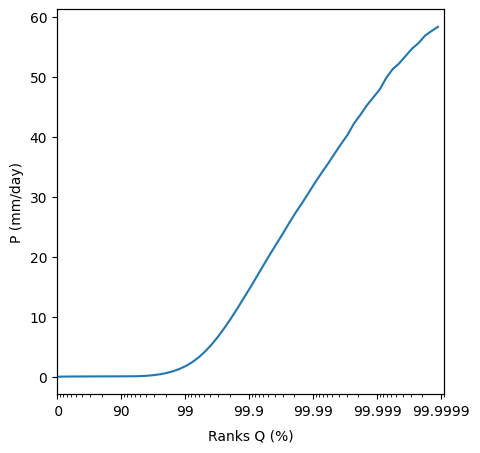

In [13]:
fig,ax = plt.subplots(figsize=(5,5))

rankmax = 99.9999
ranks = dist_pr_t.ranks[dist_pr_t.ranks<rankmax]
y = dist_pr_t.percentiles[dist_pr_t.ranks<rankmax]


subplotRanksILog(ax,ranks,y,rankmin=0,rankmax=rankmax)

# # frame
# setFrame(ax,rankmin=0,rankmax=rankmax) # in here, duplicate the outer axis for fixing independent frame
# # data
# showData(ax,dist_pr_t.ranks,dist_pr_t.percentiles)

#- labels
ax.set_xlabel('Ranks Q (%)',labelpad=25)
ax.set_ylabel('P (mm/day)')


plt.show()

# Combine sliced distribution into 1 global distribution

In [11]:
# an arbitrary time step
i_t = 900
pr_ex = loadPrec(i_t,reltab_dyam_seg).sel(lat=lat_slice)

In [7]:
# Load pre-computed distributions

dir_dist_sliced = os.path.join(DIR_OUT,'time_slices')

i_t_min = 832
i_t_max = 1917
range_t = range(i_t_min,i_t_max+1)

dict_dist_pr_sliced = {}

for i_t in range_t:
    
    # load
    dist_pr_t = pickle.load(open(os.path.join(dir_dist_sliced,'dist_pr_t_%d.pickle'%i_t),'rb'))
    # store
    dict_dist_pr_sliced[i_t] = dist_pr_t
    

In [17]:
# mean precip
pr_mean = np.array([dict_dist_pr_sliced[i_t].mean for i_t in range_t])

In [9]:
# Get indices where precip data is wrong
#
# choose to call k_t indices in range [0,1085] and i_t indices in range [832,1917]
#
k_t_skip = np.where(pr_mean < 0.01)[0] # find where precip is too small
k_t_skip = np.hstack([k_t_skip-1,k_t_skip]) # also flag the previous index
k_t_skip.sort() # sort
i_t_skip = k_t_skip + i_t_min
print("Found %d indices where precip should not be analyzed:"%len(i_t_skip),i_t_skip)

Found 22 indices where precip should not be analyzed: [ 862  863  958  959 1054 1055 1150 1151 1246 1247 1342 1343 1438 1439
 1534 1535 1630 1631 1726 1727 1822 1823]


In [10]:
# starting date
date_ref = dt.datetime(year=2016,month=8,day=1)

In [11]:
def getDateCurrent(i_t):
    
    # number of seconds elapsed
    dt_dyam = int(reltab_dyam_seg.iloc[i_t]['path_dyamond'].split('_')[-1])
    # corresponding delta
    delta_t = dt.timedelta(seconds=int(dt_dyam*7.5))
    # current date
    date_current = date_ref + delta_t
    
    return date_current

In [19]:
# time dimension
time = np.array([getDateCurrent(i_t) for i_t in range_t])

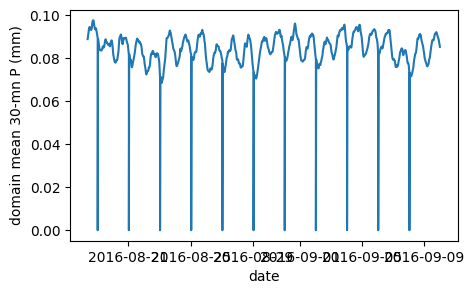

In [20]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(time,pr_mean)

ax.set_ylabel('domain mean 30-mn P (mm)')
ax.set_xlabel('date')
plt.show()

## Algorithm

In [19]:
#--- sample sizes

# sample size in subsample
N_sub = dict_dist_pr_sliced[i_t_min].size
# total number of time slices
N_t_all = len(dict_dist_pr_sliced)
# number of time slices (minus skipped slices)
N_t = len(dict_dist_pr_sliced) - len(i_t_skip)
# global sample size
N_global = N_t * N_sub

In [20]:
#--- min and max

# t-sliced min
min_sub = np.array([dict_dist_pr_sliced[i_t].vmin for i_t in range_t])
min_sub[k_t_skip] = None
# global min
min_global = np.nanmin(min_sub)
# t-sliced max
max_sub = np.array([dict_dist_pr_sliced[i_t].vmax for i_t in range_t])
max_sub[k_t_skip] = None
# global max
max_global = np.nanmax(max_sub)

In [21]:
fig,ax = plt.subplots(figsize=(5,3))

ax.plot(time,min_sub,label='min')
ax.plot(time,max_sub,label='max')

ax.set_ylabel('spatial min/max of 30-mn P (mm)')
ax.set_xlabel('date')
plt.show()

In [22]:
#---- DEV ----#

#--- main algorithm
# target_Q = 99.99999
target_Q = 99
target_nless = int(N_global*target_Q/100)

## initialize
# initial guess
Pe_i = 40
# current estimate
Pe_c = Pe_i
# search bounds
B1 = min_global
B2 = max_global
# threshold
err_thresh = max_global/10000
err = np.absolute(B2-B1)

## iterate
print('error, current estimate:')

while err > err_thresh:
    
    print(err,Pe_c)

    #- calculate position of current estimate
    
    nless = [] 
    for i_t in range_t:
        
        if i_t in i_t_skip: # skip
            nless.append(0)
            continue
        
        dist_t = dict_dist_pr_sliced[i_t]
        
        if Pe_c > dist_t.vmax:
            
            nless.append(N_sub)
            
        elif Pe_c < dist_t.vmin:
            
            nless.append(0)
        
        else:
            
            # read percentile rank Q(Pe|S)
            pr_t = np.hstack([dist_t.vmin,dist_t.percentiles,dist_t.vmax])
            Q_t = np.hstack([0,dist_t.ranks,100])
            Q_interp = interp1d(pr_t,Q_t)
            Q_est = Q_interp(Pe_c)

            # infer number of points below
            nless.append(int(N_sub*Q_est/100))
        
    nless_tot = np.sum(nless)
    
    #- update search bounds and get new estimate
    if nless_tot < target_nless:
        
        # move lower bound up
        B1 = Pe_c
        # new estimate is mean between current estimate and upper bound
        Pe_n = np.mean([Pe_c,B2])
        
    elif nless_tot > target_nless:
        
        # move upper bound down
        B2 = Pe_c
        # new estimate is mean between current estimate and lower bound
        Pe_n = np.mean([B1,Pe_c])
        
    else: # found exact equality by chance
        
        B1 = B2 = Pe_n = Pe_c
        
        
    # update error and current estimate
    err = np.absolute(B2-B1)
    Pe_c = Pe_n
     

error, current estimate:
125.90929 40
40.07597601413727 19.962011992931366
20.037988007068634 9.943017989397049
10.018994003534317 4.93352098762989
5.0094970017671585 2.428772486746311
2.5047485008835793 1.1763982363045216
1.2523742504417896 1.8025853615254164
0.6261871252208948 1.489491798914969
0.3130935626104474 1.6460385802201927
0.1565467813052237 1.7243119708728045
0.07827339065261185 1.7634486661991104
0.039136695326305926 1.7830170138622634
0.019568347663152963 1.773232840030687


In [21]:
#---- Save as function ----#

def computeGlobalPercentile(target_Q,verbose=False):

    target_nless = int(N_global*target_Q/100)

    ## initialize
    # initial guess
    Pe_i = 40
    # current estimate
    Pe_c = Pe_i
    # search bounds
    B1 = min_global
    B2 = max_global
    # threshold
    err_thresh = max_global/10000
    err = np.absolute(B2-B1)

    ## iterate
    if verbose:
        print('error, current estimate:')

    while err > err_thresh:

        if verbose:
            print(err,Pe_c)

        #- calculate position of current estimate

        nless = [] 
        for i_t in range_t:

            if i_t in i_t_skip: # skip
                nless.append(0)
                continue

            dist_t = dict_dist_pr_sliced[i_t]

            if Pe_c > dist_t.vmax:

                nless.append(N_sub)

            elif Pe_c < dist_t.vmin:

                nless.append(0)

            else:

                # read percentile rank Q(Pe|S)
                pr_t = np.hstack([dist_t.vmin,dist_t.percentiles,dist_t.vmax])
                Q_t = np.hstack([0,dist_t.ranks,100])
                Q_interp = interp1d(pr_t,Q_t)
                Q_est = Q_interp(Pe_c)

                # infer number of points below
                nless.append(int(N_sub*Q_est/100))

        nless_tot = np.sum(nless)

        #- update search bounds and get new estimate
        if nless_tot < target_nless:

            # move lower bound up
            B1 = Pe_c
            # new estimate is mean between current estimate and upper bound
            Pe_n = np.mean([Pe_c,B2])

        elif nless_tot > target_nless:

            # move upper bound down
            B2 = Pe_c
            # new estimate is mean between current estimate and lower bound
            Pe_n = np.mean([B1,Pe_c])

        else: # found exact equality by chance

            B1 = B2 = Pe_n = Pe_c


        # update error and current estimate
        err = np.absolute(B2-B1)
        Pe_c = Pe_n
    
    return Pe_c


## Do all percentiles

In [22]:
#-- initiate global distribution
dist_pr = Distribution(name='pr, DYAMOND-SAM tropics, all times',bintype='invlogQ',nd=8)

In [24]:
%%time
#-- manually compute global distribution

# store full sample size
dist_pr.size = N_global
# compute ranks
dist_pr.getInvLogRanks()
N_Q = len(dist_pr.ranks)

#- loop over all ranks to store full distribution
# init
dist_pr.percentiles = np.full(len(dist_pr.ranks),np.nan)
#- loop
for i_Q in range(N_Q):
    
    # pick target
    target_Q = dist_pr.ranks[i_Q]
    print(target_Q,end='..')
    
    # compute and store
    dist_pr.percentiles[i_Q] = computeGlobalPercentile(target_Q)
    
print()

0.0..20.567176527571853..36.90426555198067..49.88127663727278..60.18928294465028..68.3772233983162..74.8811356849042..80.0473768503112..84.15106807538886..87.41074588205832..90.0..92.05671765275719..93.69042655519807..94.98812766372727..96.01892829446503..96.83772233983163..97.48811356849042..98.00473768503112..98.41510680753889..98.74107458820583..99.0..99.20567176527571..99.3690426555198..99.49881276637272..99.6018928294465..99.68377223398316..99.74881135684905..99.80047376850311..99.84151068075388..99.87410745882059..99.9..99.92056717652757..99.93690426555199..99.94988127663727..99.96018928294464..99.96837722339832..99.9748811356849..99.98004737685031..99.98415106807539..99.98741074588206..99.99..99.99205671765276..99.99369042655519..99.99498812766373..99.99601892829446..99.99683772233982..99.9974881135685..99.99800473768504..99.99841510680754..99.99874107458821..99.99900000000001..99.99920567176528..99.99936904265552..99.99949881276638..99.99960189282945..99.99968377223398..99.9997

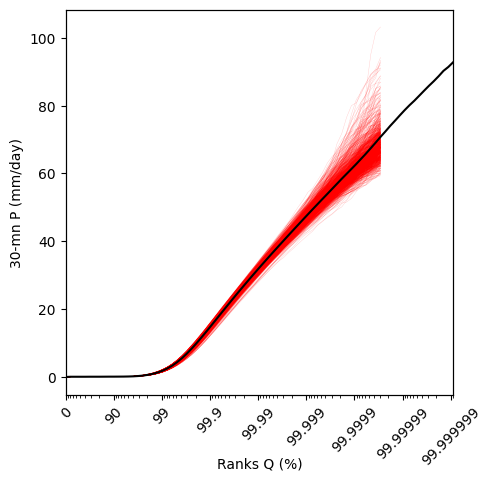

In [68]:
# show

fig,ax = plt.subplots(figsize=(5,5))

rankmax = 99.999999

for i_t in range_t:
    
    if i_t in i_t_skip:
        continue
        
    x_t = dict_dist_pr_sliced[i_t].ranks
    y_t = dict_dist_pr_sliced[i_t].percentiles
    showData(ax,x_t,y_t,color='r',linewidth=0.3,alpha=0.2,rankmin=0,rankmax=rankmax)


subplotRanksILog(ax,dist_pr.ranks,dist_pr.percentiles,rankmin=0,rankmax=rankmax,xtickrotation=45,col='k')


#- labels
ax.set_xlabel('Ranks Q (%)',labelpad=45)
ax.set_ylabel('30-mn P (mm/day)')

plt.savefig(os.path.join(DIR_FIG,'dist_pr_allt.png'),dpi=200,bbox_inches='tight')

plt.show()

## Adapt code to compute all percentiles at once

In [52]:
target_nless

array([          0,  3134077879,  5623564428,  7601033884,  9171793706,
       10419492583, 11410575029, 12197819799, 12823150548, 13319868417,
       13714425446, 14027833234, 14276781889, 14474528834, 14631604817,
       14756374704, 14855482949, 14934207426, 14996740501, 15046412288,
       15085867991, 15117208769, 15142103635, 15161878329, 15177585928,
       15190062916, 15199973741, 15207846189, 15214099496, 15219066675,
       15223012245, 15226146323, 15228635809, 15230613279, 15232184039,
       15233431738, 15234422820, 15235210065, 15235835396, 15236332113,
       15236726670, 15237040078, 15237289027, 15237486774, 15237643850,
       15237768620, 15237867728, 15237946452, 15238008986, 15238058657,
       15238098113, 15238129454, 15238154349, 15238174123, 15238189831,
       15238202308, 15238212219, 15238220091, 15238226345, 15238231312,
       15238235257, 15238238391, 15238240881, 15238242858, 15238244429,
       15238245677, 15238246668, 15238247455, 15238248080, 15238

In [87]:
%%time

#---- DEV ----#

#--- main algorithm
target_ranks = dist_pr.ranks
N_Q = len(target_ranks)

target_nless = np.array(N_global*target_ranks/100,dtype=int)
# time dimension
d_time = 1

## initialize
# initial guess
Pe_i = np.full(N_Q,40.0)
# current estimate
Pe_c = Pe_i.copy()
Pe_n = Pe_i.copy()
# search bounds
B1 = np.full(N_Q,min_global)
B2 = np.full(N_Q,max_global)
# threshold
err_thresh = max_global/10000
err = np.absolute(B2-B1)

# init to store values at each iteration
Pe_all = []
B1_all = []
B2_all = []
err_all = []

## iterate
# print('error, current estimate:')
print('error:')

while np.any(err > err_thresh):
    
    # print(u"%2.2f\u00B1%2.2f,"%(np.mean(err),np.std(err)),Pe_c)
    print(u"%2.2f\u00B1%2.2f"%(np.mean(err),np.std(err)))

    ##-- calculate position of current estimate
    
    nless = np.full((N_Q,N_t_all),np.nan) 
    for i_t in range_t:
        
        # convert indices in array starting at 0
        k_t = i_t-i_t_min
        
        if i_t in i_t_skip: # skip
            nless[:,k_t] = 0
            continue
        
        dist_t = dict_dist_pr_sliced[i_t]
        
        #- deal with precip values outside subset range
        # above max value
        select_Pabove = Pe_c > dist_t.vmax
        nless[select_Pabove,k_t] = N_sub
        # below min value
        select_Pbelow = Pe_c < dist_t.vmin
        nless[select_Pbelow,k_t] = 0
        # in between:
        select_valid = np.logical_not(np.logical_or(select_Pabove,select_Pbelow))
        
        #- interpolate percentile rank Q(Pe|S)
        # interpolation function
        pr_t = np.hstack([dist_t.vmin,dist_t.percentiles,dist_t.vmax])
        Q_t = np.hstack([0,dist_t.ranks,100])
        Q_interp = interp1d(pr_t,Q_t)
        # perform interpolation on vector
        Q_est = Q_interp(Pe_c[select_valid]) # ! only keep valid points
        # infer number of points below
        nless[select_valid,k_t] = np.array(N_sub*Q_est/100,dtype=int) # ! only assign to valid points
        
    nless_tot = np.sum(nless,axis=d_time) # add in time direction
    # print(nless_tot)
    
    ##-- update search bounds and get new estimate
    
    #- for percentiles that are smaller than target
    nless_smaller = nless_tot < target_nless
    # move lower bound up
    B1[nless_smaller] = Pe_c[nless_smaller]
    # new estimate is mean between current estimate and upper bound
    Pe_n[nless_smaller] = np.mean(np.array([Pe_c[nless_smaller],B2[nless_smaller]]),axis=0)
    
    #- for percentiles that are larger than target
    nless_larger = nless_tot > target_nless
    # move lower bound up
    B2[nless_larger] = Pe_c[nless_larger]
    # new estimate is mean between current estimate and upper bound
    Pe_n[nless_larger] = np.mean(np.array([B1[nless_larger],Pe_c[nless_larger]]),axis=0)
    
    #- percentiles found exactly equal to target, by chance
    nless_equal = nless_tot == target_nless
    B1[nless_equal] = Pe_c[nless_equal]
    B2[nless_equal] = Pe_c[nless_equal]
    Pe_n[nless_equal] = Pe_c[nless_equal]
    
    # print('nless_smaller',(nless_smaller))
    # print('nless_larger', (nless_larger))
    # print('nless_equal', (nless_equal))
    # print('B1',B1)
    # print('B2',B2)
        
    ##-- update error and current estimate
    err = np.absolute(B2-B1)
    Pe_c[:] = Pe_n
    # save steps
    Pe_all.append(Pe_c.copy())
    B1_all.append(B1.copy())
    B2_all.append(B2.copy())
    err_all.append(err.copy())
    # print("-----------------------------------------")
     

error:
125.91±0.00
60.41±22.74
30.21±11.37
15.10±5.68
7.55±2.84
3.78±1.42
1.89±0.71
0.94±0.36
0.47±0.18
0.24±0.09
0.12±0.04
0.06±0.02
0.03±0.01
0.01±0.01
CPU times: user 1.4 s, sys: 23.5 ms, total: 1.43 s
Wall time: 1.42 s


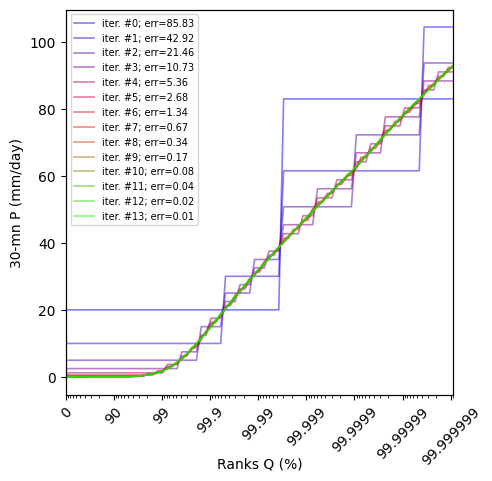

In [94]:
# Show

fig,ax = plt.subplots(figsize=(5,5))

rankmax = 99.999999
N_it = len(Pe_all)
ranks = dist_pr.ranks
# cols = iter(plt.cm.RdYlGn(np.linspace(0, 1, N_it)))
cols = iter(plt.cm.brg(np.linspace(0, 1, N_it)))

# frame
setFrame(ax,rankmin=0,rankmax=rankmax,xtickrotation=45) # in here, duplicate the outer axis for fixing independent frame

for i_it in range(N_it):
        
    y_it = Pe_all[i_it]
    # rmse = np.sqrt(np.sum(np.power(err_all[i_it],2)))
    err = np.max(err_all[i_it])
    showData(ax,ranks,y_it,color=next(cols),linewidth=1.2,alpha=0.5,rankmin=0,rankmax=rankmax,label='iter. #%d; err=%3.2f'%(i_it,err))


#- labels
ax.set_xlabel('Ranks Q (%)',labelpad=45)
ax.set_ylabel('30-mn P (mm/day)')
ax.legend(fontsize=7)

plt.savefig(os.path.join(DIR_FIG,'algorithm_iterations_sliced_extremes_all_ranks.png'),dpi=200,bbox_inches='tight')

plt.show()

In [98]:
# Save as function

def computeGlobalDistributionFromSlices(target_ranks,list_dist,inds_to_ignore,verbose=False):

    N_Q = len(target_ranks)
    N_dist = len(list_dist)

    target_nless = np.array(N_global*target_ranks/100,dtype=int)  # to adapt in class Distribution
    
    # subset dimension axis
    d_sub = 1

    ##-- initialize
    
    # initial guess
    Pe_i = np.full(N_Q,40.0)
    # current estimate
    Pe_c = Pe_i.copy()
    Pe_n = Pe_i.copy()
    Pe_all = []
    # search bounds
    B1 = np.full(N_Q,min_global) # to adapt in class Distribution
    B2 = np.full(N_Q,max_global) # to adapt in class Distribution
    B1_all = []
    B2_all = []
    # threshold
    err_thresh = max_global/10000  # to adapt in class Distribution
    err = np.absolute(B2-B1)

    ##-- iterate
    
    if verbose:
        print('error:')

    while np.any(err > err_thresh):

        if verbose:
            print(u"%2.2f\u00B1%2.2f"%(np.mean(err),np.std(err)))

        ##-- calculate position of current estimate

        nless = np.full((N_Q,N_t_all),np.nan) 
        for i_d in range(N_dist):

            if i_d in inds_to_ignore: # skip
                nless[:,i_d] = 0
                continue

            dist = list_dist[i_d]

            #- deal with precip values outside subset range
            # above max value
            select_Pabove = Pe_c > dist.vmax
            nless[select_Pabove,i_d] = N_sub  # to adapt in class Distribution
            # below min value
            select_Pbelow = Pe_c < dist_t.vmin
            nless[select_Pbelow,i_d] = 0
            # in between:
            select_valid = np.logical_not(np.logical_or(select_Pabove,select_Pbelow))

            #- interpolate percentile rank Q(Pe|S)
            # interpolation function
            perc_all = np.hstack([dist.vmin,dist.percentiles,dist.vmax])
            Q_all = np.hstack([0,dist.ranks,100])
            Q_interp = interp1d(perc_all,Q_all)
            # perform interpolation on vector
            Q_est = Q_interp(Pe_c[select_valid]) # ! only keep valid points
            # infer number of points below
            nless[select_valid,i_d] = np.array(N_sub*Q_est/100,dtype=int) # ! only assign to valid points # to adapt in class DistributionSliced (N_sub[i_d])

        nless_tot = np.sum(nless,axis=d_sub) # add in time direction

        ##-- update search bounds and get new estimate

        #- for percentiles that are smaller than target
        nless_smaller = nless_tot < target_nless
        # move lower bound up
        B1[nless_smaller] = Pe_c[nless_smaller]
        # new estimate is mean between current estimate and upper bound
        Pe_n[nless_smaller] = np.mean(np.array([Pe_c[nless_smaller],B2[nless_smaller]]),axis=0)

        #- for percentiles that are larger than target
        nless_larger = nless_tot > target_nless
        # move lower bound up
        B2[nless_larger] = Pe_c[nless_larger]
        # new estimate is mean between current estimate and upper bound
        Pe_n[nless_larger] = np.mean(np.array([B1[nless_larger],Pe_c[nless_larger]]),axis=0)

        #- percentiles found exactly equal to target, by chance
        nless_equal = nless_tot == target_nless
        B1[nless_equal] = Pe_c[nless_equal]
        B2[nless_equal] = Pe_c[nless_equal]
        Pe_n[nless_equal] = Pe_c[nless_equal]

        ##-- update error and current estimate
        err = np.absolute(B2-B1)
        Pe_c[:] = Pe_n
        
         # to adapt in class Distribution (store Pe_c in object)
    return Pe_c



### Clean up code

In [21]:
#--- sample sizes

# sample size in subsample
N_sub = dict_dist_pr_sliced[i_t_min].size
# total number of time slices
N_t_all = len(dict_dist_pr_sliced)
# number of time slices (minus skipped slices)
N_t = len(dict_dist_pr_sliced) - len(i_t_skip)
# global sample size
N_global = N_t * N_sub

#--- min and max

# t-sliced min
min_sub = np.array([dict_dist_pr_sliced[i_t].vmin for i_t in range_t])
min_sub[k_t_skip] = None
# global min
min_global = np.nanmin(min_sub)
# t-sliced max
max_sub = np.array([dict_dist_pr_sliced[i_t].vmax for i_t in range_t])
max_sub[k_t_skip] = None
# global max
max_global = np.nanmax(max_sub)

In [60]:
%%time
list_dist = list(dict_dist_pr_sliced.values())
inds_to_ignore = list(i_t_skip - i_t_min)

#-- initiate global distribution
dist_pr = DistributionChunked(name='pr, DYAMOND-SAM tropics, all times',
                              dist_chunks=list_dist,
                              chunks_to_ignore=inds_to_ignore,
                              bintype='invlogQ',nd=8)

# compute ranks
dist_pr.getInvLogRanks()
# compute all percentiles with new algorithm
dist_pr.computeDistribution()

# dist_pr.percentiles = computeGlobalDistributionFromSlices(target_ranks,list_dist,inds_to_ignore)

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.53 s
